# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# произведем загрузку библиотек
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

from imblearn.pipeline import make_pipeline as make_imblearn_pipeline

from lightgbm import LGBMRegressor

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

Признаки

* DateCrawled — дата скачивания анкеты из базы

* VehicleType — тип автомобильного кузова

* RegistrationYear — год регистрации автомобиля

* Gearbox — тип коробки передач

* Power — мощность (л. с.)

* Model — модель автомобиля

* Kilometer — пробег (км)

* RegistrationMonth — месяц регистрации автомобиля

* FuelType — тип топлива

* Brand — марка автомобиля

* Repaired — была машина в ремонте или нет

* DateCreated — дата создания анкеты

* NumberOfPictures — количество фотографий автомобиля

* PostalCode — почтовый индекс владельца анкеты (пользователя)

* LastSeen — дата последней активности пользователя

Целевой признак

* Price — цена (евро)

In [2]:
# произведем загрузку данных
pd.set_option('display.max_columns', None)

# основная информация о пользователях
try:
    df = pd.read_csv('C:/JupiterCodes/Datasets/autos.csv', sep=',') # используем сепаратор между ячейками ,
except:
    df = pd.read_csv('/datasets/autos.csv', sep=',')
    
# произведем первичную визуализацию данных
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
236178,2016-03-19 18:54:57,12499,small,2013,manual,85,golf,20000,12,petrol,volkswagen,no,2016-03-19 00:00:00,0,26529,2016-03-23 08:15:19
222814,2016-03-09 10:37:20,1450,wagon,2000,manual,84,astra,150000,9,petrol,opel,no,2016-03-09 00:00:00,0,26683,2016-04-05 15:17:07
238105,2016-03-21 20:52:33,400,NaN,2016,manual,108,vectra,150000,0,petrol,opel,no,2016-03-21 00:00:00,0,24864,2016-04-07 00:44:41
183360,2016-03-06 15:24:07,750,sedan,1999,manual,125,carisma,150000,6,petrol,mitsubishi,no,2016-03-06 00:00:00,0,56477,2016-04-04 22:44:25
20916,2016-03-29 10:50:07,2299,small,2002,manual,80,fiesta,150000,9,petrol,ford,no,2016-03-29 00:00:00,0,78579,2016-04-03 19:17:21
346295,2016-03-26 13:55:23,1699,small,2000,manual,101,fabia,150000,1,petrol,skoda,no,2016-03-26 00:00:00,0,28857,2016-04-06 01:47:08
130893,2016-03-20 12:56:11,6999,wagon,2007,auto,170,passat,150000,10,gasoline,volkswagen,no,2016-03-20 00:00:00,0,35576,2016-03-20 19:24:33
343685,2016-03-21 16:44:49,1550,sedan,2003,manual,101,focus,150000,5,gasoline,ford,no,2016-03-21 00:00:00,0,71522,2016-04-06 15:45:28
105909,2016-03-09 13:39:39,575,wagon,2001,auto,150,NaN,150000,2,gasoline,audi,yes,2016-03-09 00:00:00,0,27419,2016-03-14 18:19:07
295869,2016-03-19 09:52:17,2500,NaN,2017,manual,150,golf,150000,10,NaN,volkswagen,no,2016-03-19 00:00:00,0,73035,2016-03-25 09:48:11


In [3]:
# оценка данных
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
# размер датафрейма
df.shape

(354369, 16)

In [5]:
# подсчитаем количество дубликатов
df.duplicated().sum()

4

In [6]:
# удалим дубликаты
df.drop_duplicates(inplace=True)

In [7]:
# произведем проверку пропусков
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
# визуализируем названия колонок
print(df.columns)

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')


После анализа признаков принято решение об удалении следующих колонок:


* DateCrawled — дата скачивания анкеты из базы

* RegistrationMonth — месяц регистрации автомобиля

* DateCreated — дата создания анкеты

* NumberOfPictures — количество фотографий автомобиля

* PostalCode — почтовый индекс владельца анкеты (пользователя)

* LastSeen — дата последней активности пользователя

Все они не несут информации для модели или могут обеспечить утечку данных.

In [9]:
drop_col = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

In [10]:
df1 = df.drop(drop_col, axis=1)

print(df1.columns)

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')


### Исследование колонки VehicleType

Совокупность двух признаком Model и Brand не определяетоднозначно тип кузова, у одной модели он может быть различным. Заполним все пропуски в этой колонке значением  'other'

In [11]:
df1['VehicleType'] = df1['VehicleType'].fillna('other')

### Исследование колонки Gearbox

In [12]:
df1['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [13]:
df1['Gearbox'].sort_values().value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

Ввиду того, что в этой колонке возможно только два значения и почти 80% из них - это manual, заполним пропуски именно этим значением.

In [14]:
df1['Gearbox'] = df1['Gearbox'].fillna('manual')

In [15]:
df1['Gearbox'].isna().sum()

0

### Исследование колонки Model

In [16]:
df1['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [17]:
df1['Model'].replace(['range_rover_sport', 'rangerover', 'range_rover_evoque'], 'range_rover', inplace=True)

In [18]:
df1['Model'].replace(['serie_1', 'serie_2', 'serie_3'], 'serie', inplace=True)

In [19]:
df1['Model'].sort_values().value_counts().tail(20)

croma         45
v60           42
lodgy         35
delta         35
terios        35
9000          31
charade       27
b_max         26
musa          25
materia       18
200           18
amarok        16
q3            15
kappa         15
serie         14
samara        13
gl            13
elefantino    11
kalina         9
i3             8
Name: Model, dtype: int64

Второе место по количеству включений занимает тип 'other'.

In [20]:
df1[df1['Model'] == 'other']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
24,500,sedan,1990,manual,118,other,150000,petrol,mercedes_benz,yes
38,11900,other,2002,manual,129,other,150000,gasoline,volkswagen,no
39,1500,bus,1984,manual,70,other,150000,gasoline,mercedes_benz,no
52,1400,other,2016,manual,55,other,5000,NaN,hyundai,NaN
...,...,...,...,...,...,...,...,...,...,...
354290,2500,small,2007,manual,60,other,125000,petrol,hyundai,NaN
354302,5990,bus,1984,auto,0,other,70000,petrol,chevrolet,NaN
354316,3300,coupe,1957,manual,40,other,100000,petrol,trabant,no
354325,12800,convertible,1991,manual,211,other,150000,petrol,porsche,no


Заменим пропуски на тип 'other'.

In [21]:
df1['Model'] = df1['Model'].fillna('other')

### Исследование колонки FuelType

In [22]:
df1['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [23]:
df1['FuelType'].sort_values().value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Заменим пропуски на тип 'other'.

In [24]:
df1['FuelType'] = df1['FuelType'].fillna('other')

### Исследование колонки Repaired

In [25]:
df1['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [26]:
df1['Repaired'].sort_values().value_counts()

no     247158
yes     36053
Name: Repaired, dtype: int64

Заменим пропуски на тип 'no'.

In [27]:
df1['Repaired'] = df1['Repaired'].fillna('no')

### Исследование колонки RegistrationYear

In [28]:
df1['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

В анализ включим автомобили, которые были выпушены в период с 50-х годов по 2019.

In [29]:
# тут и далее будем удалять строки, поэтому введем df2
df2 = df1[(df1['RegistrationYear'] >= 1950) & (df1['RegistrationYear'] <= 2016)]

df2.shape

(339589, 10)

### Исследование колонки Power

In [30]:
# df1['Power'].unique()

Заявленная мощность автомобиля в 2000 и более является необычно высоким значением. Оно не может быть измерено в обычных лошадиных силах (HP) или киловаттах (kW), так как такая мощность превосходит стандартные показатели для большинства автомобилей, доступных на рынке.

На 2021 год, самым мощным автомобилем, доступным в США, является электрический гиперкар Rimac CTwo. Этот автомобиль имеет общую мощность около 1914 лошадиных сил (1427 киловатт). 

In [31]:
df2 = df1[(df1['Power'] >= 5) & (df1['Power'] <= 2000)]

df2.shape

(313937, 10)

### Исследование колонки Kilometer

In [32]:
df1['Kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000], dtype=int64)

### Анализ данных

In [33]:
# произведем проверку пропусков
df2.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [34]:
# подсчитаем количество дубликатов после всех замен
df2.duplicated().sum()

48038

In [35]:
# удалим дубликаты
df2.drop_duplicates(inplace=True)

In [36]:
df2.shape

(265899, 10)

In [37]:
# зададим функцию, показывающию корреляцию на тепловой диаграмме

def plotCorrelationMatrix(df, graphWidth):
    filename = 'Матрица корреляции'
    corr = df.corr()
    # фильтруем матрицу корреляций для переменных с корреляцией > 0.9
    # corr = corr[corr > 0.9]
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=20) 
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=20) 
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            text = f'{corr.iloc[i, j]:.2f}'
            plt.text(j, i, text, ha='center', va='center', color='black')
    
    plt.title(f'{filename}', fontsize=35)
    plt.show()

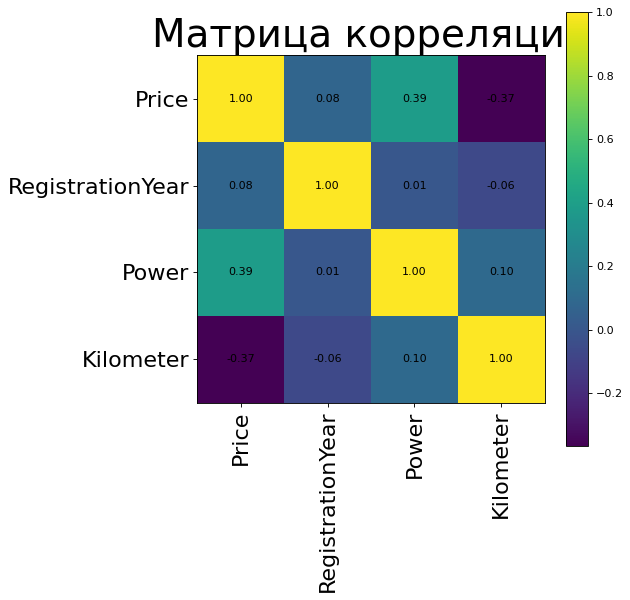

In [38]:
# матрица корреляции для переменных датасета

plotCorrelationMatrix(df2, 7)

In [39]:
# составим список с колонками, в которых находятся числовые значения
num_cols = df2.select_dtypes(include='number').columns

In [40]:
def plotHistNumCols(df, graph_width, graph_height):
    fig = plt.figure(figsize=(graph_width, graph_height))
    for i, var in enumerate(num_cols):
        ax = fig.add_subplot(2, 3, i+1)
        df[var].hist(bins=50, ax=ax)
        ax.set_title(var)

    plt.tight_layout()
    plt.show()

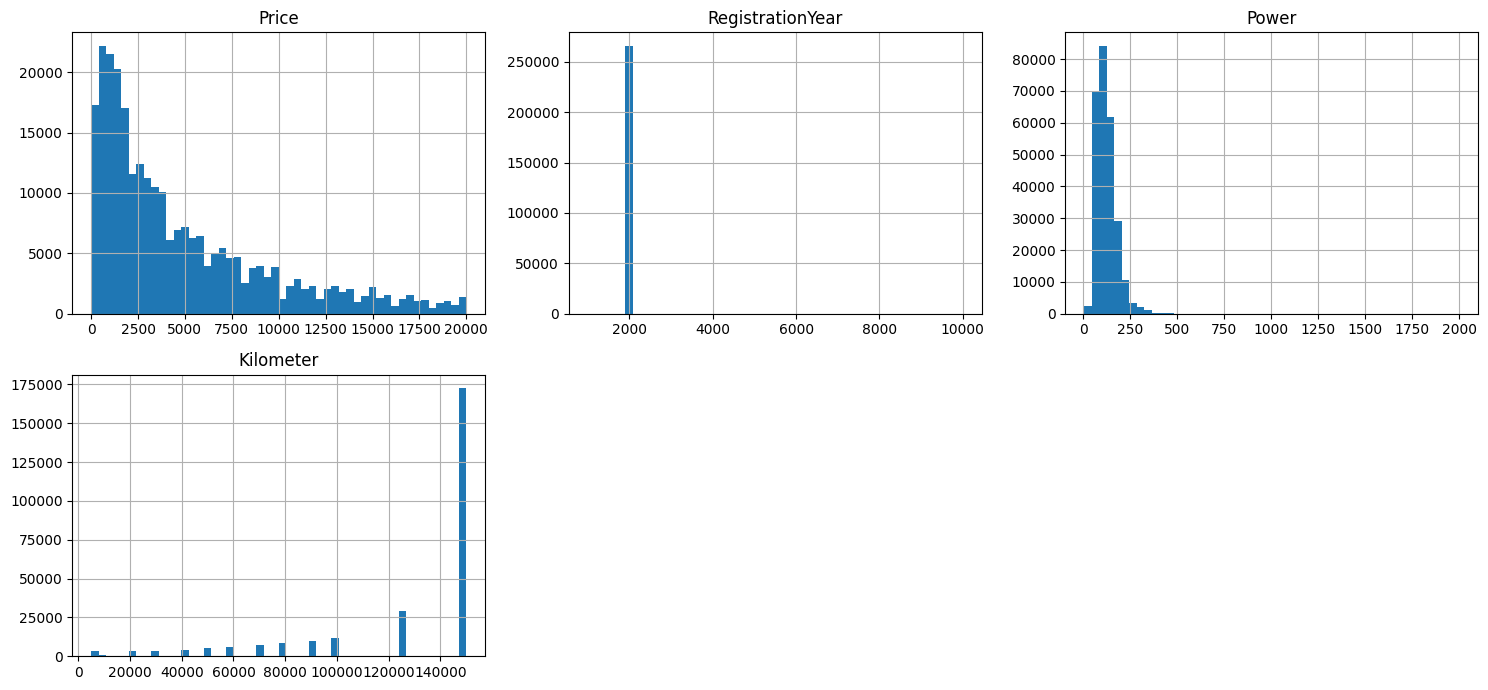

In [41]:
# построим гистограммы колонок с числовыми значениями
plotHistNumCols(df2, 15, 7)

### Выводы по разделу

Получен изначальный массив данных размером 354369, 16.

В данных обнаружены дубликаты и пропуски. Дубликаты удалены. Пропуски обработанны по каждому признаку отдельно.

Удален ряд признаков, не несущих информацию для модели. К этому ряду относятся следующие колонки: ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

В числовых признаках обнаружены аномальные значения. К примеру, дата регистрации машины относилась к 3500 году или мощность машины составляла 10000 л.с.

Вычленены диапазоны нормальных числовых диапазонов признаков. Не входящие в них строки удалены.

Произведена повторная проверка дубликатов после расставления заглушек. Размер нового массива данных составил 265899, 10.

## Обучение моделей

### Разделение на обучающие и целевые признаки

In [42]:
features = df2.drop(['Price'], axis=1)
target = df2['Price']

### Разделениеисходных данных на обучающие и тестовые выборки 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Конвейр

Выделим колонки по их типу в наборе признаков.

In [44]:
cat_colunmns_list = features.select_dtypes(include=['object', 'category']).columns.tolist()

cat_colunmns_list

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [45]:
cat_colunmns = ['VehicleType', 'Model', 'FuelType', 'Brand']

In [46]:
binary_colunmns = ['Gearbox', 'Repaired']

In [47]:
non_binary_numeric_cols = features.select_dtypes(include=['int64', 'float64']).nunique() > 2
num_columns = non_binary_numeric_cols[non_binary_numeric_cols].index.tolist()
num_columns

['RegistrationYear', 'Power', 'Kilometer']

Создадим конвейр со следующими шагами:

1. Создается объект `scaler` класса `StandardScaler` из библиотеки `sklearn.preprocessing`. `StandardScaler` используется для стандартизации данных путем приведения каждого признака к среднему значению 0 и стандартному отклонению 1. Этот шаг полезен, чтобы привести все признаки к одному масштабу и предотвратить преобладание признаков с большими значениями над признаками с меньшими значениями.

2. Создается объект `poly` класса `PolynomialFeatures` из библиотеки `sklearn.preprocessing`. `PolynomialFeatures` используется для генерации полиномиальных признаков на основе исходных признаков. При использовании `PolynomialFeatures`, каждый признак преобразуется в комбинацию степеней, что позволяет модели лучше улавливать нелинейные взаимодействия между признаками.

3. Создается объект `o_encoder` класса `OrdinalEncoder` из библиотеки `sklearn.preprocessing`. `OrdinalEncoder` используется для кодирования категориальных признаков целыми числами на основе порядка значений в каждом признаке. Это полезно, когда значения категорий имеют внутренний упорядоченный ранг.


In [48]:
scaler = StandardScaler()
poly = PolynomialFeatures()
# drop_correlation = DropCorrelatedFeatures(threshold=0.9)

o_encoder = OrdinalEncoder()
oh_encoder = OneHotEncoder(drop='first', sparse=False)

num_pipeline = make_imblearn_pipeline(scaler, poly)


column_transformer = make_column_transformer((num_pipeline, num_columns),
                                             (o_encoder, cat_colunmns),
                                             (oh_encoder, binary_colunmns),
                                              remainder='passthrough')
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures())]),
                                 ['RegistrationYear', 'Power', 'Kilometer']),
                                ('ordinalencoder', OrdinalEncoder(),
                                 ['VehicleType', 'Model', 'FuelType', 'Brand']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['Gearbox', 'Repaired'])])

In [49]:
tree = DecisionTreeRegressor(random_state=42)  

forest = RandomForestRegressor(random_state=42) 

GBM = LGBMRegressor(random_state=42, verbose=0, force_row_wise=True)  

In [50]:
pipeline = make_imblearn_pipeline(column_transformer, 
           VotingRegressor(estimators=[('tree', tree),
                                       ('forest', forest), 
                                       ('GBM', GBM)
                                      ]))
                           

# введем имя переменной ensemble
pipeline.steps[-1] = ('ensemble', pipeline.steps[-1][1])

pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures())]),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['VehicleType', 'Model',
                                                   'FuelType', 'Brand']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Gearbox', 'Repaired'])])),
                ('ensemble',
                 VotingRegressor(estimators=[('tree',
                                              DecisionTreeRegressor(random_state=42)),
                                             ('forest',
                                              RandomForestRegressor(random_state=42)),
                                             ('GBM',
                                              LGBMRegressor(force_row_wise=True,
                                                            random_state=42,
                                                            verbose=0))]))])

In [51]:
%%time

pipeline.fit(X_train, y_train)

CPU times: total: 1min 57s
Wall time: 1min 56s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures())]),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['VehicleType', 'Model',
                                                   'FuelType', 'Brand']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Gearbox', 'Repaired'])])),
                ('ensemble',
                 VotingRegressor(estimators=[('tree',
                                              DecisionTreeRegressor(random_state=42)),
                                             ('forest',
                                              RandomForestRegressor(random_state=42)),
                                             ('GBM',
                                              LGBMRegressor(force_row_wise=True,
                                                            random_state=42,
                                                            verbose=0))]))])

RMSE позволяет оценивать, насколько сильно отклоняются предсказанные значения от фактических значений. Чем меньше значение RMSE, тем лучше модель способна делать точные предсказания.

RMSE очень похожа на среднеквадратичную ошибку (MSE), но в отличие от нее, RMSE имеет ту же размерность, что и измеряемая переменная, что делает ее легкой для интерпретации. Важно отметить, что RMSE получается извлечением квадратного корня из MSE.

In [52]:
%%time

# выполним кросс-валидацию и вычислим оценку RMSE
scores = -cross_val_score(pipeline, X_train, y_train, cv=5, 
                          scoring='neg_mean_squared_error',
                          error_score="raise",
                          n_jobs=-1)

rmse_scores = np.sqrt(scores)

# выводим оценки RMSE для каждой итерации
print("RMSE Scores:", rmse_scores)

# выводим среднюю оценку RMSE
print("Average RMSE:", np.mean(rmse_scores))

RMSE Scores: [1865.32476373 1846.92623321 1868.02556563 1851.66009931 1807.96918363]
Average RMSE: 1847.9811690996328
CPU times: total: 359 ms
Wall time: 3min 12s


In [57]:
np.mean(rmse_scores)/y_train.mean()

0.38221879465817615

### Выводы по разделу

Данные разделены на обучающие и целевые признаки. Создано две выборки: тренировочная и тестовая.

Для автоматизации процесса предобработки данных и обучения моделей принято решение использовать конвеер. Обучены три модели: дерева решений, случайного леса и градиентного бустинга.

Для объединения несколько моделей и получения прогноза на основе голосования или усреднения применен алгоритм ансамбля для регрессии - VotingRegressor.

Вот некоторые преимущества использования VotingRegressor:

1. Увеличение устойчивости и снижение ошибки прогнозирования: Когда разные модели имеют различные предположения или особенности, их объединение позволяет снизить смещение (bias) и дисперсию (variance) в итоговых прогнозах, что может привести к улучшению качества модели.

2. Универсальность: VotingRegressor может работать с различными типами моделей, такими как линейная регрессия, решающие деревья, градиентный бустинг и другие. Это позволяет комбинировать разнообразные модели и использовать их сильные стороны.

3. Меньшая вероятность переобучения: Объединение нескольких моделей снижает риск переобучения модели на обучающих данных.

С целью проверки произведена кросс-валидация. Получившиеся метрика удовлетворяет условию задания.

## Анализ моделей

In [53]:
# Создание и обучение модели-заглушки
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

# Получение предсказаний на тестовом наборе данных
y_pred = dummy.predict(X_test)

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 4652.324966124605


In [54]:
%%time

y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 1843.7775059167714
CPU times: total: 2.5 s
Wall time: 2.96 s


Для оценки адекватности полученных результатов применен метод сравнения с дамми-моделью. Результаты такого сравнения сведены в таблицу:

| Модель                                          | RMSE            |Время обучения модели    |
|:----------------------------------------------- |:---------------:|:-----------------------:|
| Ансамбль                                        | 1843.777        |1min 58s                 |    
| Дамми-модель                                    | 4652.324        | -                       | 

Мы получили на тестовой выборке результат, удовлетворяющий заданной точности 2500.

Объединение нескольких моделей требует больше времени для обучения и предсказания, однако ансамблевые методы дают более устойчивые предсказания. В данном случае временные затраты в 118 секунд можно считать приемлимыми.

Пути улучшения предсказания: оптимизация гиперпараметров модели методом сетевого поиска. В данном случае этот метод не использовался, так как он существенно увеличивает время счета, мы же получили удовлетворительную точность даже на базовых значениях.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

## Вывод

Получен изначальный массив данных размером 354369, 16.

В данных обнаружены дубликаты и пропуски. Дубликаты удалены. Пропуски обработанны по каждому признаку отдельно.

Удален ряд признаков, не несущих информацию для модели. К этому ряду относятся следующие колонки: ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

В числовых признаках обнаружены аномальные значения. К примеру, дата регистрации машины относилась к 3500 году или мощность машины составляла 10000 л.с.

Вычленены диапазоны нормальных числовых диапазонов признаков. Не входящие в них строки удалены.

Произведена повторная проверка дубликатов после расставления заглушек. Размер нового массива данных составил 265899, 10.

Данные разделены на обучающие и целевые признаки. Создано две выборки: тренировочная и тестовая.

Для автоматизации процесса предобработки данных и обучения моделей принято решение использовать конвеер. Обучены три модели: дерева решений, случайного леса и градиентного бустинга.

Для объединения несколько моделей и получения прогноза на основе голосования или усреднения применен алгоритм ансамбля для регрессии - VotingRegressor.

Вот некоторые преимущества использования VotingRegressor:

1. Увеличение устойчивости и снижение ошибки прогнозирования: Когда разные модели имеют различные предположения или особенности, их объединение позволяет снизить смещение (bias) и дисперсию (variance) в итоговых прогнозах, что может привести к улучшению качества модели.

2. Универсальность: VotingRegressor может работать с различными типами моделей, такими как линейная регрессия, решающие деревья, градиентный бустинг и другие. Это позволяет комбинировать разнообразные модели и использовать их сильные стороны.

3. Меньшая вероятность переобучения: Объединение нескольких моделей снижает риск переобучения модели на обучающих данных.

С целью проверки произведена кросс-валидация. Получившиеся метрика удовлетворяет условию задания.

Для оценки адекватности полученных результатов применен метод сравнения с дамми-моделью. Результаты такого сравнения сведены в таблицу:

| Модель                                          | RMSE            |Время обучения модели    |
|:----------------------------------------------- |:---------------:|:-----------------------:|
| Ансамбль                                        | 1843.777        |1min 58s                 |    
| Дамми-модель                                    | 4652.324        | -                       | 

Мы получили на тестовой выборке результат, удовлетворяющий заданной точности 2500.

Объединение нескольких моделей требует больше времени для обучения и предсказания, однако ансамблевые методы дают более устойчивые предсказания. В данном случае временные затраты в 118 секунд можно считать приемлимыми.

Пути улучшения предсказания: оптимизация гиперпараметров модели методом сетевого поиска. В данном случае этот метод не использовался, так как он существенно увеличивает время счета, мы же получили удовлетворительную точность даже на базовых значениях.